v1.0

The objective of this notebook is to:
- examine the reasons behind model inaccuracy and explore potential solutions.

In [ ]:
import time
t_start = time.time()

# Setup Environment

## Install Modules

In [ ]:
#!pip install yellowbrick
#!pip install joblib
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


## Import Modules

In [ ]:
# Base libraries
import os
import re
import platform

# Scientific libraries
import numpy as np
import pandas as pd

# Specific libraries

# Machine learning libraries
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=0.8)

# Helper libraries
from tqdm import tqdm

tqdm.pandas()
from watermark import watermark
import gc  # garbage collection to optimize memory usage, use gc.collect()
import warnings

warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Define Parameters

In [ ]:
# sklearn
seed = 42

## Helper Functions

# 3.0 Load Data

## Import the files containing all the features generated during the feature creation and transformation stage

In [ ]:
# Mount Google Drive and set the path to the root directory of the project
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_ROOT = "/content/drive/MyDrive/MADS/SIADS696/Environment/"
except:
    print("Using shortcut location to load data.")
    PATH_ROOT = "/content/drive/MyDrive/SIADS696/Environment/"

# Define the paths to different directories and files in the project
PATHS = {
    "data": os.path.join(PATH_ROOT, "data"),
    "data_raw": os.path.join(PATH_ROOT, "data", "raw"),
    "data_int": os.path.join(PATH_ROOT, "data", "interim"),
    "data_pro": os.path.join(PATH_ROOT, "data", "processed"),
    "models": os.path.join(PATH_ROOT, "models"),
    "reports": os.path.join(PATH_ROOT, "reports"),
    "figures": os.path.join(PATH_ROOT, "reports", "figures"),
}

# Define the datasets with names as keys and file paths as values
DATASETS = {
    "kfold_RFECV_features": os.path.join(PATHS["data_int"], "RF_base_model_RFECV_features_results_for_failure_analysis.parquet.gzip"),
    "training_raw": os.path.join(PATHS["data_raw"], "WikiLarge_Train.csv")
}

# load each dataset and store it in a variable with the same name as its key in the DATASETS dictionary
for name, filename in DATASETS.items():
    if filename.endswith(".csv"):
        locals()[f"df_{name}"] = pd.read_csv(os.path.join(PATH_ROOT, filename))
    elif filename.endswith(".parquet.gzip"):
        locals()[f"df_{name}"] = pd.read_parquet(os.path.join(PATH_ROOT, filename), engine='pyarrow')
    else:
        raise ValueError(f"Unsupported file format for dataset {name}")

Mounted at /content/drive


# 4.0 Model Failure Analysis

## Identify the features with the most entries where the predicted label (y_pred) differs from the actual label (y_true)

In [ ]:
# Print the column names of the DataFrame
print(df_kfold_RFECV_features.columns.tolist())

['aoa_aoa_bird_lem_max', 'aoa_aoa_bird_lem_mean', 'aoa_aoa_bird_lem_min', 'aoa_aoa_bird_lem_sum', 'aoa_aoa_bristol_lem_max', 'aoa_aoa_bristol_lem_mean', 'aoa_aoa_bristol_lem_min', 'aoa_aoa_bristol_lem_sum', 'aoa_aoa_cort_lem_max', 'aoa_aoa_cort_lem_mean', 'aoa_aoa_cort_lem_min', 'aoa_aoa_cort_lem_sum', 'aoa_aoa_kup_lem_max', 'aoa_aoa_kup_lem_mean', 'aoa_aoa_kup_lem_min', 'aoa_aoa_kup_lem_sum', 'aoa_aoa_kup_max', 'aoa_aoa_kup_mean', 'aoa_aoa_kup_min', 'aoa_aoa_kup_sum', 'aoa_aoa_schock_max', 'aoa_aoa_schock_mean', 'aoa_aoa_schock_min', 'aoa_aoa_schock_sum', 'aoa_dom_pos_subtlex_max', 'aoa_dom_pos_subtlex_mean', 'aoa_dom_pos_subtlex_min', 'aoa_dom_pos_subtlex_sum', 'aoa_freq_pm_max', 'aoa_freq_pm_mean', 'aoa_freq_pm_min', 'aoa_freq_pm_sum', 'aoa_perc_known_lem_mean', 'aoa_perc_known_lem_min', 'aoa_perc_known_lem_sum', 'aoa_perc_known_mean', 'aoa_perc_known_min', 'aoa_perc_known_sum', 'crb_concm_mean', 'crb_concm_sum', 'crb_concsd_mean', 'crb_concsd_sum', 'crb_perc_known_sum', 'crb_subtle

In [ ]:
# Get the column names of the dataframe and convert to set for efficiency
features_kfold_base_model = set(df_kfold_RFECV_features.columns)

# Define a set of unwanted values to be excluded from the feature list
unwanted_values = {'original_text', 'cleaned_text', 'label', 'Random Forerst-y_pred', 'ExTreeClf-y_pred', 'XGBoost-y_pred', 'CatBoost-y_pred', 'Logistic Regression-y_pred', 'Gaussian NB-y_pred', 'Multinomial NB-y_pred', 'Decision Tree-y_pred', 'Voting CLF-y_pred', 'y_true', 'y_pred'}

# Use set difference to exclude unwanted values and convert back to list
features_kfold_base_model = list(features_kfold_base_model - unwanted_values)

# Print the resulting feature list
print(features_kfold_base_model)

#df_kfold_RFECV_features.to_csv('/content/drive/MyDrive/MADS/SIADS696/Environment/my_data.csv', index=False)

['aoa_dom_pos_subtlex_max', 'stats_max_chars_word', 'aoa_dom_pos_subtlex_sum', 'aoa_aoa_cort_lem_max', 'stats_word_count', 'rs_ari_en2', 'rs_lix2', 'aoa_aoa_bird_lem_min', 'rs_ari_en1', 'crb_perc_known_sum', 'stats_avg_letter_per_word', 'aoa_freq_pm_min', 'rs_fre_multi1', 'stats_rrb_count', 'aoa_aoa_cort_lem_sum', 'stats_equalsign_count', 'aoa_aoa_schock_sum', 'stats_char_count', 'rs_difficult_words_en', 'aoa_dom_pos_subtlex_mean', 'aoa_perc_known_mean', 'stats_syllable_count', 'aoa_perc_known_lem_mean', 'crb_concm_sum', 'nltk_pos_VBP', 'nltk_pos_RB', 'aoa_perc_known_min', 'stats_frac_word_comma', 'rs_flesch_kincaid_grade_en', 'nltk_pos_NN', 'stats_comma_count', 'aoa_aoa_bristol_lem_min', 'aoa_freq_pm_mean', 'aoa_aoa_bird_lem_mean', 'w2v_ft_sen2vec_mean', 'crb_subtlex_mean', 'stats_frac_mini_word', 'aoa_aoa_kup_min', 'nltk_pos_JJ', 'w2v_gen_avg_word2vec_mean', 'rs_spache_readability_en', 'nltk_pos_FW', 'stats_max_syllables_word', 'aoa_freq_pm_sum', 'aoa_aoa_kup_lem_min', 'stats_reading

## Analyzing the "stats_char_count" feature

### Clustering of Mismatched Cases by Character Count

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='Density'>

<AxesSubplot:xlabel='stats_char_count', ylabel='Density'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'True Labels')

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Predicted Labels')

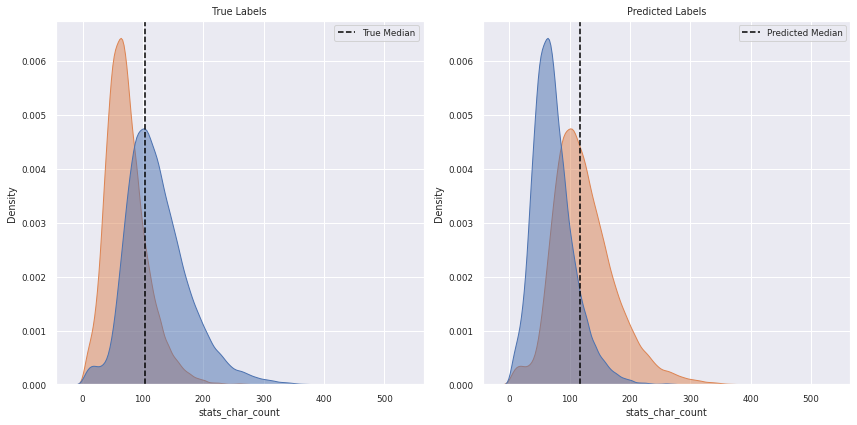

In [ ]:
# Extract the features and labels
X = np.array(df_kfold_RFECV_features['stats_char_count']).reshape(-1, 1)
y_true = df_kfold_RFECV_features['label']
y_pred = df_kfold_RFECV_features['y_pred']

# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=seed).fit(X)
labels = kmeans.labels_

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X.ravel(), 'label': y_true, 'y_pred': y_pred, 'cluster': labels})

# Display only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Create a density plot of the true labels
    sns.kdeplot(data=df_mismatch, x='stats_char_count', hue='label', fill=True, alpha=0.5, ax=axs[0])
    true_median = np.median(X[y_true == 1])
    axs[0].axvline(x=true_median, color='black', linestyle='--', label='True Median')

    # Create a density plot of the predicted labels
    sns.kdeplot(data=df_mismatch, x='stats_char_count', hue='y_pred', fill=True, alpha=0.5, ax=axs[1])
    pred_median = np.median(X[y_pred == 1])
    axs[1].axvline(x=pred_median, color='black', linestyle='--', label='Predicted Median')

    axs[0].set_xlabel('stats_char_count')
    axs[0].set_ylabel('Density')
    axs[0].set_title('True Labels')
    axs[0].legend()

    axs[1].set_xlabel('stats_char_count')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Predicted Labels')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

### Mismatched Cases of Predicted and Actual Labels

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='label'>

<AxesSubplot:xlabel='stats_char_count', ylabel='label'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Label')

Text(0.5, 1.0, 'True and Predicted Labels for Mismatched Cases')

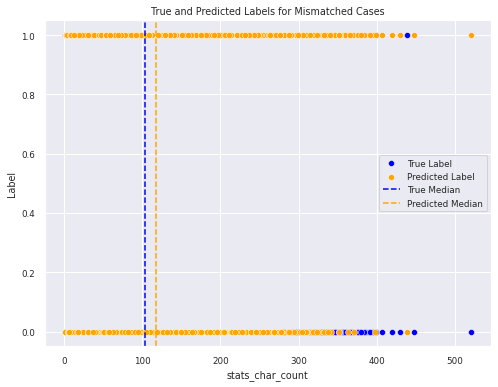

In [ ]:
# Extract the features and labels
X = np.array(df_kfold_RFECV_features['stats_char_count']).reshape(-1, 1)
y_true = df_kfold_RFECV_features['label']
y_pred = df_kfold_RFECV_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X.ravel(), 'label': y_true, 'y_pred': y_pred})

# Display only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create a scatter plot of the true and predicted labels
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=df_mismatch, x='stats_char_count', y='label', color='blue', label='True Label', ax=ax)
    sns.scatterplot(data=df_mismatch, x='stats_char_count', y='y_pred', color='orange', label='Predicted Label', ax=ax)

    # Add vertical lines for the median values of stats_char_count
    true_median = np.median(X[y_true == 1])
    pred_median = np.median(X[y_pred == 1])

    ax.axvline(x=true_median, color='blue', linestyle='--', label='True Median')
    ax.axvline(x=pred_median, color='orange', linestyle='--', label='Predicted Median')

    ax.set_xlabel('stats_char_count')
    ax.set_ylabel('Label')
    ax.set_title('True and Predicted Labels for Mismatched Cases')
    ax.legend()

    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

### Distribution of stats_char_count for Mismatched Cases

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='Count'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of stats_char_count for Mismatched Cases')

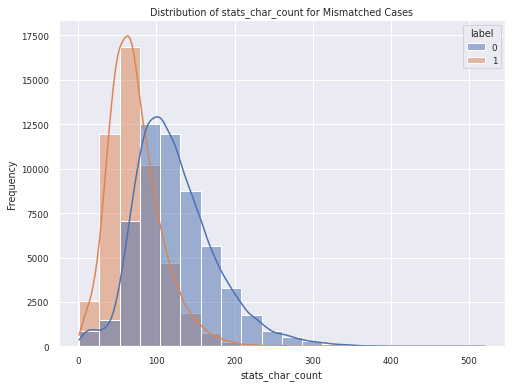

In [ ]:
# Extract the features and labels
X = np.array(df_kfold_RFECV_features['stats_char_count']).reshape(-1, 1)
y_true = df_kfold_RFECV_features['label']
y_pred = df_kfold_RFECV_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X.ravel(), 'label': y_true, 'y_pred': y_pred})

# Filter out only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create a distribution plot for stats_char_count
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(data=df_mismatch, x='stats_char_count', hue='label', kde=True, alpha=0.5, bins=20, ax=ax)
    ax.set_xlabel('stats_char_count')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of stats_char_count for Mismatched Cases')

    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

### Exploring Mismatched Predictions incl. violin plot of the true and predicted labels

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='Count'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'True Labels')

<AxesSubplot:xlabel='stats_char_count', ylabel='Count'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Predicted Labels')

<AxesSubplot:xlabel='label', ylabel='stats_char_count'>

Text(0.5, 0, 'True Label')

Text(0, 0.5, 'stats_char_count')

Text(0.5, 1.0, 'True and Predicted Labels')

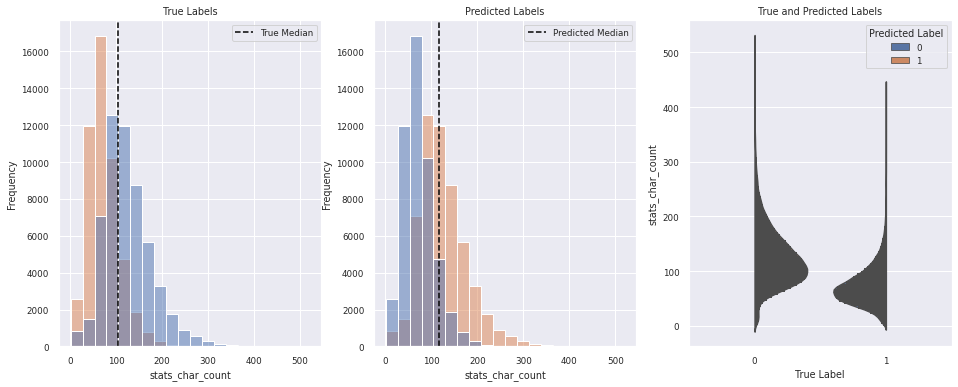

In [ ]:
# Extract the features and labels
X = np.array(df_kfold_RFECV_features['stats_char_count']).reshape(-1, 1)
y_true = df_kfold_RFECV_features['label']
y_pred = df_kfold_RFECV_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X.ravel(), 'label': y_true, 'y_pred': y_pred})

# Filter out only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create a distribution plot for stats_char_count
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    # Create a histogram of the true labels
    sns.histplot(data=df_mismatch, x='stats_char_count', hue='label', kde=False, alpha=0.5, bins=20, ax=axs[0])
    true_median = np.median(X[y_true == 1])
    axs[0].axvline(x=true_median, color='black', linestyle='--', label='True Median')
    axs[0].set_xlabel('stats_char_count')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('True Labels')
    axs[0].legend()

    # Create a histogram of the predicted labels
    sns.histplot(data=df_mismatch, x='stats_char_count', hue='y_pred', kde=False, alpha=0.5, bins=20, ax=axs[1])
    pred_median = np.median(X[y_pred == 1])
    axs[1].axvline(x=pred_median, color='black', linestyle='--', label='Predicted Median')
    axs[1].set_xlabel('stats_char_count')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Predicted Labels')
    axs[1].legend()

    # Create a violin plot of the true and predicted labels
    sns.violinplot(data=df_mismatch, x='label', y='stats_char_count', hue='y_pred', split=True, scale='count', inner='stick', ax=axs[2])
    axs[2].set_xlabel('True Label')
    axs[2].set_ylabel('stats_char_count')
    axs[2].set_title('True and Predicted Labels')
    axs[2].legend(title='Predicted Label')

    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

## Analyzing the "stats_char_count" and "w2v_gen_avg_word2vec_mean" features

### Scatter plots of mismatched cases

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'Mismatched Cases for Label 0')

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'Mismatched Cases for Label 1')

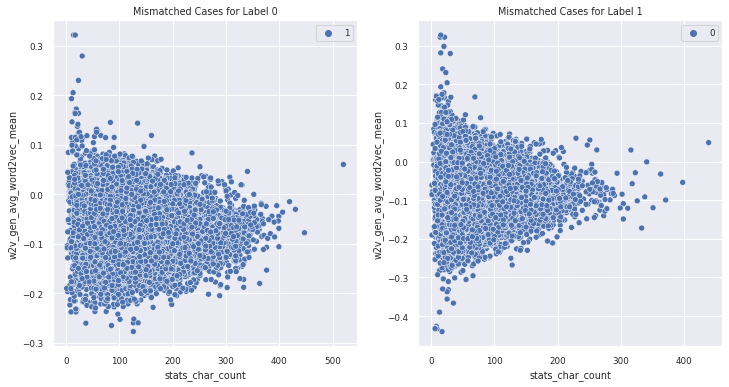

In [ ]:
# Extract the features and labels
df_features = df_kfold_RFECV_features[df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1]
X = df_features[['stats_char_count', 'w2v_gen_avg_word2vec_mean']].values
y_true = df_features['label']
y_pred = df_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X[:, 0], 'w2v_gen_avg_word2vec_mean': X[:, 1], 'label': y_true, 'y_pred': y_pred})

# Filter out only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create two scatter plots of the two features, colored by label
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.scatterplot(data=df_mismatch[df_mismatch['label'] == 0], x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='y_pred', ax=axs[0])
    axs[0].set_xlabel('stats_char_count')
    axs[0].set_ylabel('w2v_gen_avg_word2vec_mean')
    axs[0].set_title('Mismatched Cases for Label 0')
    axs[0].legend()

    sns.scatterplot(data=df_mismatch[df_mismatch['label'] == 1], x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='y_pred', ax=axs[1])
    axs[1].set_xlabel('stats_char_count')
    axs[1].set_ylabel('w2v_gen_avg_word2vec_mean')
    axs[1].set_title('Mismatched Cases for Label 1')
    axs[1].legend()

    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

### Distribution of stats_char_count and w2v_gen_avg_word2vec_mean by Label

Cases where the predicted label does not match the actual label:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'Mismatched Cases for Label 0')

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'Mismatched Cases for Label 1')

Text(0.5, 1.05, 'Distribution of stats_char_count and w2v_gen_avg_word2vec_mean by Label')

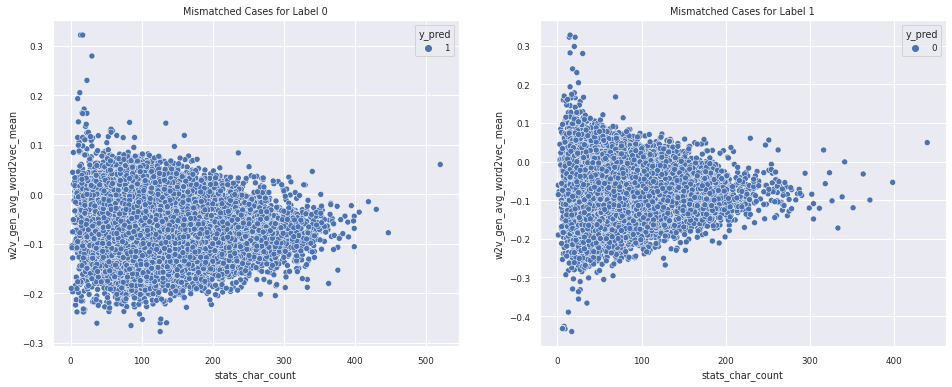

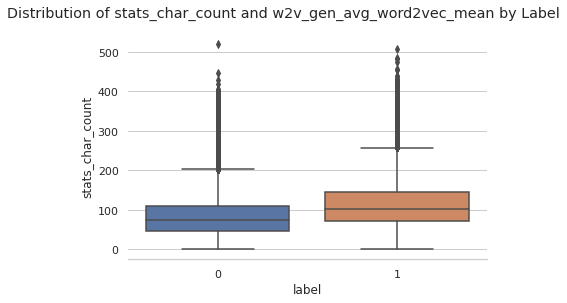

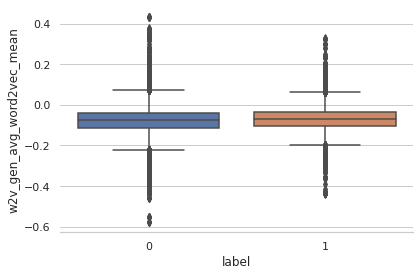

In [ ]:
# Extract the features and labels
df_features = df_kfold_RFECV_features[df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1]
X = df_features[['stats_char_count', 'w2v_gen_avg_word2vec_mean']].values
y_true = df_features['label']
y_pred = df_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X[:, 0], 'w2v_gen_avg_word2vec_mean': X[:, 1], 'label': y_true, 'y_pred': y_pred})

# Filter out only the cases where the predicted label does not match the actual label
df_mismatch = df[df['label'] != df['y_pred']]
if not df_mismatch.empty:
    print("Cases where the predicted label does not match the actual label:")
    print(df_mismatch)

    # Create two scatter plots of the two features, colored by label
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(data=df_mismatch[df_mismatch['label'] == 0], x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='y_pred', ax=axs[0])
    axs[0].set_xlabel('stats_char_count')
    axs[0].set_ylabel('w2v_gen_avg_word2vec_mean')
    axs[0].set_title('Mismatched Cases for Label 0')

    sns.scatterplot(data=df_mismatch[df_mismatch['label'] == 1], x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='y_pred', ax=axs[1])
    axs[1].set_xlabel('stats_char_count')
    axs[1].set_ylabel('w2v_gen_avg_word2vec_mean')
    axs[1].set_title('Mismatched Cases for Label 1')

    # Create a grid of box plots for the two features, colored by label
    sns.set(style="whitegrid")
    g = sns.catplot(x="label", y="stats_char_count", data=df, kind="box", height=4, aspect=1.5, ax=axs[1])
    g.despine(left=True)
    g.set_ylabels("stats_char_count")
    g.fig.suptitle('Distribution of stats_char_count and w2v_gen_avg_word2vec_mean by Label', y=1.05)

    g = sns.catplot(x="label", y="w2v_gen_avg_word2vec_mean", data=df, kind="box", height=4, aspect=1.5, ax=axs[1])
    g.despine(left=True)
    g.set_ylabels("w2v_gen_avg_word2vec_mean")

    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

### Scatter Plot of stats_char_count and w2v_gen_avg_word2vec_mean by Label and Prediction Matches

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'All Cases for Label 0')

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'All Cases for Label 1')

Text(160, 0.3, 'Areas of Focus for Failure Analysis')

Text(160, 0.3, 'Areas of Focus for Failure Analysis')

Text(0.5, 0.98, 'Analysis of matched and mismatched cases for each label with respect to the stats_char_count and w2v_gen_avg_word2vec_mean features')

<function matplotlib.pyplot.show(close=None, block=None)>

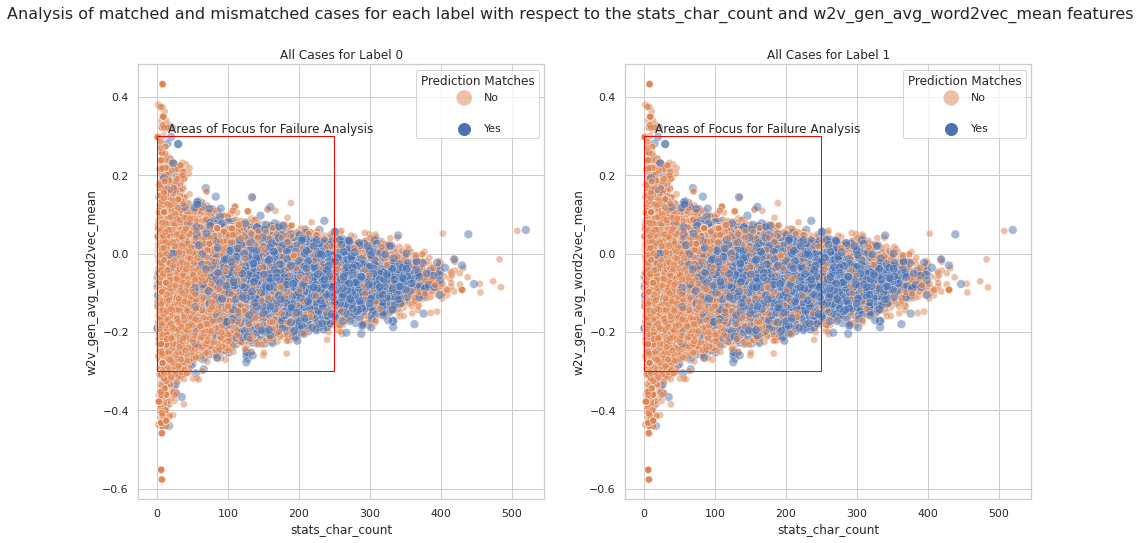

In [ ]:
import matplotlib.patches as patches

# Extract the features and labels
df_features = df_kfold_RFECV_features[df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1]
X = df_features[['stats_char_count', 'w2v_gen_avg_word2vec_mean']].values
y_true = df_features['label']
y_pred = df_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X[:, 0], 'w2v_gen_avg_word2vec_mean': X[:, 1], 'label': y_true, 'y_pred': y_pred})

# Create a new column for matching predictions
df['match'] = df['label'] == df['y_pred']
df['mismatch'] = df['label'] != df['y_pred']

# Create two scatter plots of the two features, colored by label and matching predictions
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
sns.scatterplot(data=df, x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='match', size='mismatch', alpha=0.5, sizes=[50, 75], ax=axs[0])
axs[0].set_xlabel('stats_char_count')
axs[0].set_ylabel('w2v_gen_avg_word2vec_mean')
axs[0].set_title('All Cases for Label 0')
leg = axs[0].legend(title='Prediction Matches', labels=['No', '', 'Yes'], markerscale=2, markerfirst=True)

sns.scatterplot(data=df, x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='match', size='mismatch', alpha=0.5, sizes=[50, 75], ax=axs[1])
axs[1].set_xlabel('stats_char_count')
axs[1].set_ylabel('w2v_gen_avg_word2vec_mean')
axs[1].set_title('All Cases for Label 1')
leg = axs[1].legend(title='Prediction Matches', labels=['No', '', 'Yes'], markerscale=2, markerfirst=True)

# Add the red empty box to each subplot separately
rect1 = patches.Rectangle((0, -0.3), 250, 0.6, edgecolor='red', fill=False)
axs[0].add_patch(rect1)
axs[0].text(160, 0.3, 'Areas of Focus for Failure Analysis', ha='center', va='bottom', fontsize=12)

rect2 = patches.Rectangle((0, -0.3), 250, 0.6, edgecolor='red', fill=False)
axs[1].add_patch(rect2)
axs[1].text(160, 0.3, 'Areas of Focus for Failure Analysis', ha='center', va='bottom', fontsize=12)

plt.suptitle('Analysis of matched and mismatched cases for each label with respect to the stats_char_count and w2v_gen_avg_word2vec_mean features', fontsize=16)
plt.show

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'All Cases for Label 0')

<AxesSubplot:xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'All Cases for Label 1')

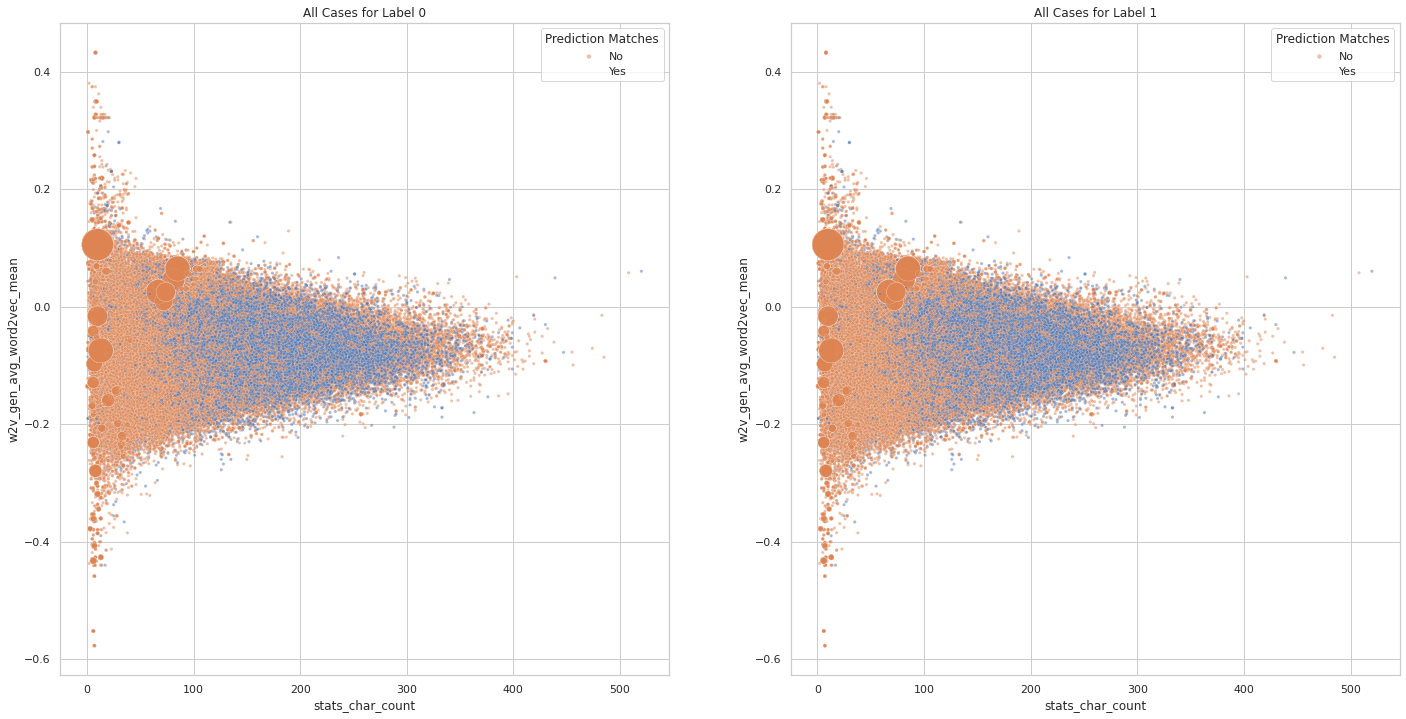

In [ ]:
# Extract the features and labels
df_features = df_kfold_RFECV_features[df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1]
X = df_features[['stats_char_count', 'w2v_gen_avg_word2vec_mean']].values
y_true = df_features['label']
y_pred = df_features['y_pred']

# Create a DataFrame with the feature and label data
df = pd.DataFrame({'stats_char_count': X[:, 0], 'w2v_gen_avg_word2vec_mean': X[:, 1], 'label': y_true, 'y_pred': y_pred})

# Create a new column for matching predictions
df['match'] = df['label'] == df['y_pred']

# Create a new column for the count of matching predictions for each combination of features
df['match_count'] = df.groupby(['stats_char_count', 'w2v_gen_avg_word2vec_mean', 'match'])['match'].transform('count')

# Create two scatter plots of the two features, colored by label and matching predictions
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

# Set the minimum and maximum sizes for the bubbles
min_size = 10
max_size = 1000

# Set the scaling factor to adjust the size of the bubbles
scale_factor = (max_size - min_size) / df['match_count'].max()

sns.scatterplot(data=df, x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='match', size='match_count', alpha=0.5, sizes=(min_size, max_size), ax=axs[0])
axs[0].set_xlabel('stats_char_count')
axs[0].set_ylabel('w2v_gen_avg_word2vec_mean')
axs[0].set_title('All Cases for Label 0')
axs[0].legend(title='Prediction Matches', labels=['No', 'Yes'], markerscale=0.2)

sns.scatterplot(data=df, x='stats_char_count', y='w2v_gen_avg_word2vec_mean', hue='match', size='match_count', alpha=0.5, sizes=(min_size, max_size), ax=axs[1])
axs[1].set_xlabel('stats_char_count')
axs[1].set_ylabel('w2v_gen_avg_word2vec_mean')
axs[1].set_title('All Cases for Label 1')
axs[1].legend(title='Prediction Matches', labels=['No', 'Yes'], markerscale=0.2)

#plt.suptitle('Analysis of matched and mismatched cases for each label with respect to the stats_char_count and w2v_gen_avg_word2vec_mean features', fontsize=16)
plt.show()

### Heatmaps of Mismatched Cases for Label 0 and Label 1

Text(0.5, 1.0, 'Label 0\n26.60% of cases are misclassified (96.34% of all cases captured in range)')

<AxesSubplot:title={'center':'Label 0\n26.60% of cases are misclassified (96.34% of all cases captured in range)'}, xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

(0.0, 250.0)

(-0.3, 0.3)

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 1.0, 'Label 1\n24.18% of cases are misclassified (95.92% of all cases captured in range)')

<AxesSubplot:title={'center':'Label 1\n24.18% of cases are misclassified (95.92% of all cases captured in range)'}, xlabel='stats_char_count', ylabel='w2v_gen_avg_word2vec_mean'>

(0.0, 250.0)

(-0.3, 0.3)

Text(0.5, 0, 'stats_char_count')

Text(0, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 0.98, 'Percentage of mismatched cases for each label related to the stats_char_count and w2v_gen_avg_word2vec_mean features')

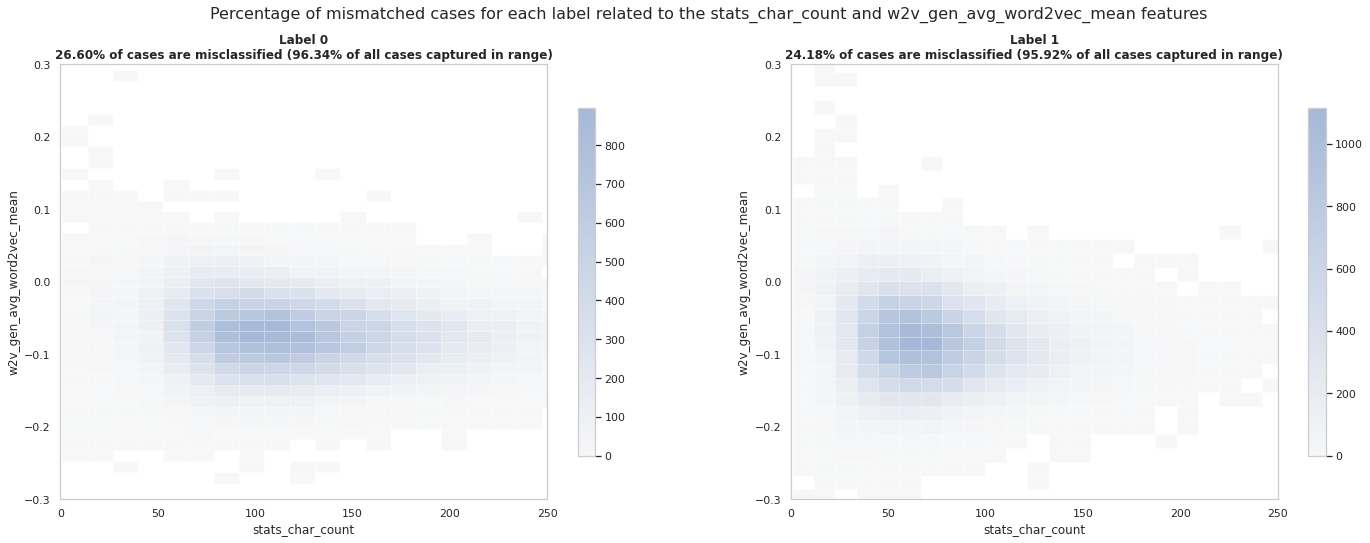

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Extract the features and labels
df = df_kfold_RFECV_features[(df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1) &
                             (df_kfold_RFECV_features['label'] != df_kfold_RFECV_features['y_pred'])]

if not df.empty:
    # Define the ranges of values for stats_char_count and w2v_gen_avg_word2vec_mean
    range_stats_char_count = range(0, 251)
    range_w2v_gen_avg_word2vec_mean = np.linspace(-0.2, 0.1, 41)

    # Create two heatmaps of the two features, colored by the percentage of mismatches
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    for i, label in enumerate([0, 1]):
        df_label = df[df['label'] == label]

        count_all_rows_for_lable = len(df_kfold_RFECV_features[(df_kfold_RFECV_features['label'] == label)])

        count_all_rows_in_range = len(df_kfold_RFECV_features[(df_kfold_RFECV_features['label'] == label) &
                                            (df_kfold_RFECV_features['stats_char_count'] >= 0) &
                                            (df_kfold_RFECV_features['stats_char_count'] <= 250) &
                                            (df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] >= -0.3) &
                                            (df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] <= 0.3)])

        count_mismatched = ((df_label['label'] != df_label['y_pred']) & 
                            (df_label['stats_char_count'] >= 0) & 
                            (df_label['stats_char_count'] <= 250) & 
                            (df_label['w2v_gen_avg_word2vec_mean'] >= -0.3) & 
                            (df_label['w2v_gen_avg_word2vec_mean'] <= 0.3)).sum()

        percent_mismatched_in_range = 100 * count_mismatched / count_all_rows_in_range
        percent_rows_in_range = 100 * count_all_rows_in_range / count_all_rows_for_lable
        
        axs[i].set_title(f"Label {label}\n{percent_mismatched_in_range:.2f}% of cases are misclassified ({percent_rows_in_range:.2f}% of all cases captured in range)", fontweight='bold', fontsize=12)

        sns.histplot(data=df_label, x='stats_char_count', 
                     y='w2v_gen_avg_word2vec_mean', 
                     bins=40, cbar=True, 
                     cbar_kws={"shrink": 0.8}, ax=axs[i], 
                     weights=df_label['label'] != df_label['y_pred'], 
                     cmap=sns.color_palette("light:b", as_cmap=True),
                     alpha=0.5, edgecolor=None)
        axs[i].set_xlim(0, 250)
        axs[i].set_ylim(-0.3, 0.3)
        axs[i].set_xlabel('stats_char_count')
        axs[i].set_ylabel('w2v_gen_avg_word2vec_mean')
        axs[i].grid(False)

    plt.suptitle('Percentage of mismatched cases for each label related to the stats_char_count and w2v_gen_avg_word2vec_mean features', fontsize=16)
    plt.show()
else:
    print("No cases where the predicted label does not match the actual label.")

In [ ]:
# Apply the filtering conditions and store the resulting DataFrame in a variable
df_filtered = df_kfold_RFECV_features

# Create a new DataFrame with the original_text, label, y_pred, and comparison columns
df_comparison = pd.DataFrame({
    'original_text': df_filtered['original_text'],
    'label': df_filtered['label'],
    'y_pred': df_filtered['y_pred'],
    'stats_char_count': df_filtered['stats_char_count'],
    'w2v_gen_avg_word2vec_mean': df_filtered['w2v_gen_avg_word2vec_mean'],
    'comparison': np.where(df_filtered['label'] == df_filtered['y_pred'], 'match', 'mismatch')
})

# Add a new column to the DataFrame to indicate whether the row is within the specified ranges
df_comparison['in_range'] = np.where((df_filtered['stats_char_count'] >= 0) &
                                     (df_filtered['stats_char_count'] <= 250) &
                                     (df_filtered['w2v_gen_avg_word2vec_mean'] >= -0.3) &
                                     (df_filtered['w2v_gen_avg_word2vec_mean'] <= 0.3), 'yes', 'no')

# Export the new DataFrame to a CSV file
df_comparison.to_csv(os.path.join(PATHS["data_int"], '05_02_failure_analysis_mismatch.csv'), index=False)

## Analyzing the "stats_char_count", "w2v_gen_avg_word2vec_mean" and "aoa_aoa_kup_lem_mean" features

### Creating three 3D charts to visualize feature mismatches for Label 0

Text(0.5, 0, 'stats_char_count')

Text(0.5, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 0')

Text(0.5, 0, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 0.5, 'aoa_aoa_kup_lem_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 0')

Text(0.5, 0, 'stats_char_count')

Text(0.5, 0.5, 'aoa_aoa_kup_lem_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 0')

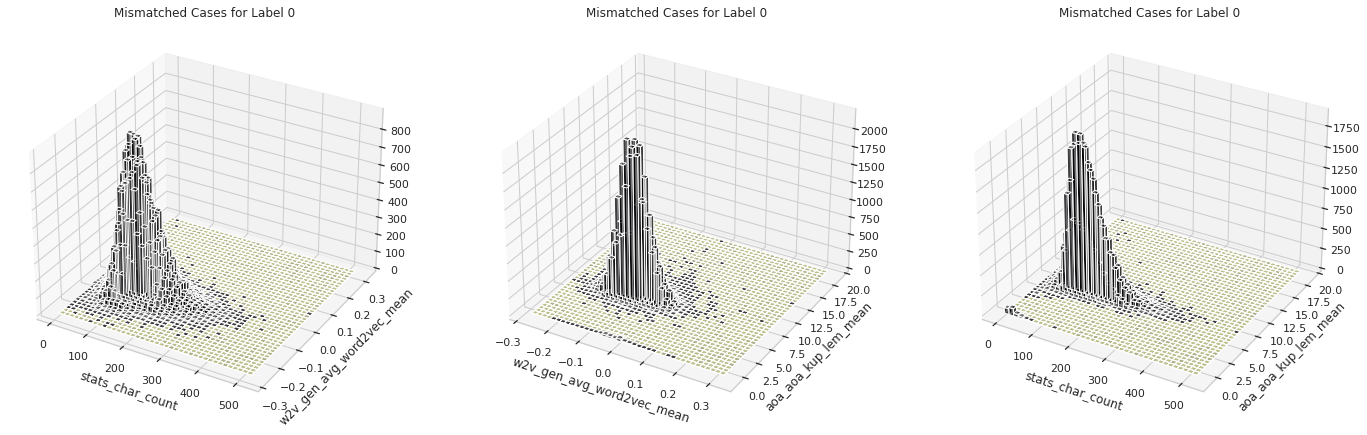

In [ ]:
from matplotlib import cm

# Extract the features and labels
df = df_kfold_RFECV_features[(df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1) &
                             (df_kfold_RFECV_features['label'] != df_kfold_RFECV_features['y_pred'])]

if not df.empty:
    # Create heatmaps of the three features, colored by the number of mismatches
    fig = plt.figure(figsize=(24, 8))

    ax1 = fig.add_subplot(131, projection='3d')
    hist1, xedges1, yedges1 = np.histogram2d(df[df['label'] == 0]['stats_char_count'], df[df['label'] == 0]['w2v_gen_avg_word2vec_mean'], bins=40, weights=df[df['label'] == 0]['label'] != df[df['label'] == 0]['y_pred'])
    xpos1, ypos1 = np.meshgrid(xedges1[:-1], yedges1[:-1], indexing='ij')
    zpos1 = np.zeros_like(hist1)
    dx1, dy1 = np.meshgrid(np.diff(xedges1), np.diff(yedges1), indexing='ij')
    dz1 = hist1
    cmap1 = cm.get_cmap('inferno_r')
    ax1.bar3d(xpos1.flatten(), ypos1.flatten(), zpos1.flatten(), dx1.flatten(), dy1.flatten(), dz1.flatten(), color=cmap1(dz1.flatten()), alpha=0.5)
    ax1.set_xlabel('stats_char_count')
    ax1.set_ylabel('w2v_gen_avg_word2vec_mean')
    ax1.set_title('Mismatched Cases for Label 0')

    ax2 = fig.add_subplot(132, projection='3d')
    hist2, xedges2, yedges2 = np.histogram2d(df[df['label'] == 0]['w2v_gen_avg_word2vec_mean'], df[df['label'] == 0]['aoa_aoa_kup_lem_mean'], bins=40, weights=df[df['label'] == 0]['label'] != df[df['label'] == 0]['y_pred'])
    xpos2, ypos2 = np.meshgrid(xedges2[:-1], yedges2[:-1], indexing='ij')
    zpos2 = np.zeros_like(hist2)
    dx2, dy2 = np.meshgrid(np.diff(xedges2), np.diff(yedges2), indexing='ij')
    dz2 = hist2
    cmap2 = cm.get_cmap('inferno_r')
    ax2.bar3d(xpos2.flatten(), ypos2.flatten(), zpos2.flatten(), dx2.flatten(), dy2.flatten(), dz2.flatten(), color=cmap2(dz2.flatten()), alpha=0.5)
    ax2.set_xlabel('w2v_gen_avg_word2vec_mean')
    ax2.set_ylabel('aoa_aoa_kup_lem_mean')
    ax2.set_title('Mismatched Cases for Label 0')

    ax3 = fig.add_subplot(133, projection='3d')
    hist3, xedges3, yedges3 = np.histogram2d(df[df['label'] == 0]['stats_char_count'], df[df['label'] == 0]['aoa_aoa_kup_lem_mean'], bins=40, weights=df[df['label'] == 0]['label'] != df[df['label'] == 0]['y_pred'])
    xpos3, ypos3 = np.meshgrid(xedges3[:-1], yedges3[:-1], indexing='ij')
    zpos3 = np.zeros_like(hist3)
    dx3, dy3 = np.meshgrid(np.diff(xedges3), np.diff(yedges3), indexing='ij')
    dz3 = hist3
    cmap3 = cm.get_cmap('inferno_r')
    ax3.bar3d(xpos3.flatten(), ypos3.flatten(), zpos3.flatten(), dx3.flatten(), dy3.flatten(), dz3.flatten(), color=cmap3(dz3.flatten()), alpha=0.5)
    ax3.set_xlabel('stats_char_count')
    ax3.set_ylabel('aoa_aoa_kup_lem_mean')
    ax3.set_title('Mismatched Cases for Label 0')

    plt.show()

### Creating three 3D charts to visualize feature mismatches for Label 1

Text(0.5, 0, 'stats_char_count')

Text(0.5, 0.5, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 1')

Text(0.5, 0, 'w2v_gen_avg_word2vec_mean')

Text(0.5, 0.5, 'aoa_aoa_kup_lem_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 1')

Text(0.5, 0, 'stats_char_count')

Text(0.5, 0.5, 'aoa_aoa_kup_lem_mean')

Text(0.5, 0.92, 'Mismatched Cases for Label 1')

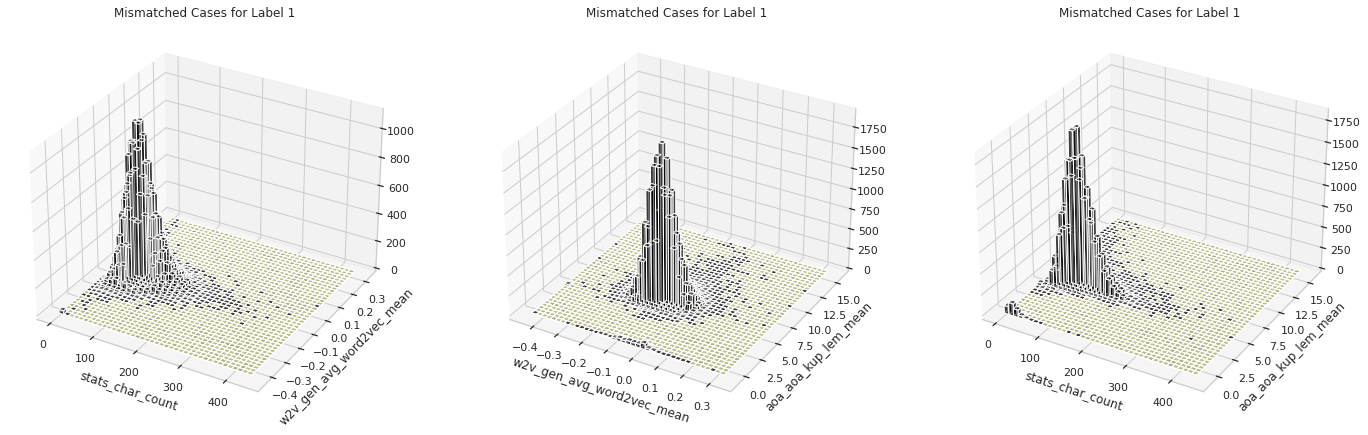

In [ ]:
from matplotlib import cm

# Extract the features and labels
df = df_kfold_RFECV_features[(df_kfold_RFECV_features['w2v_gen_avg_word2vec_mean'] != -1) &
                             (df_kfold_RFECV_features['label'] != df_kfold_RFECV_features['y_pred'])]

if not df.empty:
    # Create heatmaps of the three features, colored by the number of mismatches
    fig = plt.figure(figsize=(24, 8))

    ax1 = fig.add_subplot(131, projection='3d')
    hist1, xedges1, yedges1 = np.histogram2d(df[df['label'] == 1]['stats_char_count'], df[df['label'] == 1]['w2v_gen_avg_word2vec_mean'], bins=40, weights=df[df['label'] == 1]['label'] != df[df['label'] == 1]['y_pred'])
    xpos1, ypos1 = np.meshgrid(xedges1[:-1], yedges1[:-1], indexing='ij')
    zpos1 = np.zeros_like(hist1)
    dx1, dy1 = np.meshgrid(np.diff(xedges1), np.diff(yedges1), indexing='ij')
    dz1 = hist1
    cmap1 = cm.get_cmap('inferno_r')
    ax1.bar3d(xpos1.flatten(), ypos1.flatten(), zpos1.flatten(), dx1.flatten(), dy1.flatten(), dz1.flatten(), color=cmap1(dz1.flatten()), alpha=0.5)
    ax1.set_xlabel('stats_char_count')
    ax1.set_ylabel('w2v_gen_avg_word2vec_mean')
    ax1.set_title('Mismatched Cases for Label 1')

    ax2 = fig.add_subplot(132, projection='3d')
    hist2, xedges2, yedges2 = np.histogram2d(df[df['label'] == 1]['w2v_gen_avg_word2vec_mean'], df[df['label'] == 1]['aoa_aoa_kup_lem_mean'], bins=40, weights=df[df['label'] == 1]['label'] != df[df['label'] == 1]['y_pred'])
    xpos2, ypos2 = np.meshgrid(xedges2[:-1], yedges2[:-1], indexing='ij')
    zpos2 = np.zeros_like(hist2)
    dx2, dy2 = np.meshgrid(np.diff(xedges2), np.diff(yedges2), indexing='ij')
    dz2 = hist2
    cmap2 = cm.get_cmap('inferno_r')
    ax2.bar3d(xpos2.flatten(), ypos2.flatten(), zpos2.flatten(), dx2.flatten(), dy2.flatten(), dz2.flatten(), color=cmap2(dz2.flatten()), alpha=0.5)
    ax2.set_xlabel('w2v_gen_avg_word2vec_mean')
    ax2.set_ylabel('aoa_aoa_kup_lem_mean')
    ax2.set_title('Mismatched Cases for Label 1')

    ax3 = fig.add_subplot(133, projection='3d')
    hist3, xedges3, yedges3 = np.histogram2d(df[df['label'] == 1]['stats_char_count'], df[df['label'] == 1]['aoa_aoa_kup_lem_mean'], bins=40, weights=df[df['label'] == 1]['label'] != df[df['label'] == 1]['y_pred'])
    xpos3, ypos3 = np.meshgrid(xedges3[:-1], yedges3[:-1], indexing='ij')
    zpos3 = np.zeros_like(hist3)
    dx3, dy3 = np.meshgrid(np.diff(xedges3), np.diff(yedges3), indexing='ij')
    dz3 = hist3
    cmap3 = cm.get_cmap('inferno_r')
    ax3.bar3d(xpos3.flatten(), ypos3.flatten(), zpos3.flatten(), dx3.flatten(), dy3.flatten(), dz3.flatten(), color=cmap3(dz3.flatten()), alpha=0.5)
    ax3.set_xlabel('stats_char_count')
    ax3.set_ylabel('aoa_aoa_kup_lem_mean')
    ax3.set_title('Mismatched Cases for Label 1')

    plt.show()

# 6.0 Watermark

In [ ]:
% watermark

UsageError: Line magic function `%` not found.


In [ ]:
% watermark --iversions

In [ ]:
t_end = time.time()
total_runtime = t_end - t_start
total_runtime_min = round((total_runtime / 60), 2)
print(str(total_runtime_min) + " minutes")